In [17]:
#Importing important librarys
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
le = LabelEncoder()
import warnings
warnings.filterwarnings('ignore')

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
mBusData = pd.read_csv('/content/drive/MyDrive/datasets/Iot_processed/IoT_Modbus.csv')
mBusData.head()

,date,time,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil,label,type
0,31-Mar-19,12:36:55,53287,1463,33518,23014,0,normal
1,31-Mar-19,12:36:58,41029,55891,26004,50645,0,normal
2,31-Mar-19,12:36:58,41029,55891,26004,50645,0,normal
3,31-Mar-19,12:37:00,64661,40232,33460,44046,0,normal
4,31-Mar-19,12:37:01,64661,40232,33460,44046,0,normal


In [20]:
mBusData.drop('type', axis = 1, inplace=True)
mBusData.drop(mBusData.iloc[:, 0:2], axis = 1, inplace=True)
mBusData.head()

,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil,label
0,53287,1463,33518,23014,0
1,41029,55891,26004,50645,0
2,41029,55891,26004,50645,0
3,64661,40232,33460,44046,0
4,64661,40232,33460,44046,0


In [21]:
# import matplotlib.pyplot as plt
# columns = mBusData.columns
# for col in columns:
#     print("col: ", col)
#     mBusData[col].hist(bins = 100)
#     plt.show()

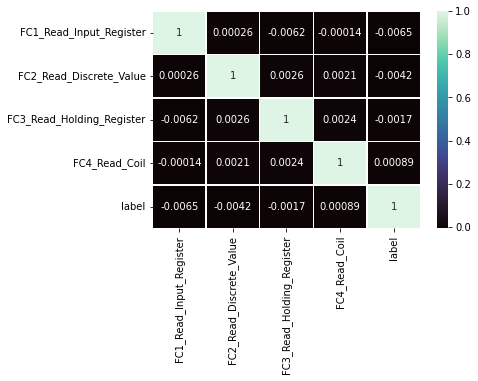

In [22]:
sns.heatmap(mBusData.corr(), annot=True, linewidth = 0.5, cmap = 'mako')

# **Train Test with Skfold**

In [34]:
x=mBusData[['FC1_Read_Input_Register','FC2_Read_Discrete_Value','FC3_Read_Holding_Register','FC4_Read_Coil']]
y=mBusData['label' ]

In [35]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=8, shuffle = True, random_state=3)

In [36]:
for train_index, test_index in skf.split(x, y):
    x_train, x_test, y_train, y_test = x.iloc[train_index], x.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

In [37]:
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler()
x = sc.fit_transform(x)

In [27]:
type(x)

numpy.ndarray

In [28]:
# from sklearn.preprocessing import StandardScaler
# sc= StandardScaler()
# x = sc.fit_transform(x)

In [42]:
from interpret.glassbox import LogisticRegression
    
lr = LogisticRegression(class_weight="balanced")
lr.fit(x_train, y_train) #Training the model
y_pred_lr = lr.predict(x_test)
print(y_pred_lr)# printing predictions


#Accuracy Score

from sklearn.metrics import accuracy_score
lrAccuracy = round(accuracy_score(y_test, y_pred_lr)*100,2)
print("Accuracy of LR: ",lrAccuracy)

#F1 Score

from sklearn.metrics import f1_score
lrF1 = round(f1_score(y_test, y_pred_lr)*100,2)
print("f1_score of LR: ",lrF1)

#AUC Score

from sklearn.metrics import roc_auc_score
lrAuc = round(roc_auc_score (y_test, y_pred_lr)*100,2)
print('AUC Score of LR:',lrAuc)

[1 0 1 ... 0 0 0]
Accuracy of LR:  56.18
f1_score of LR:  28.74
AUC Score of LR: 50.23


AttributeError: ignored

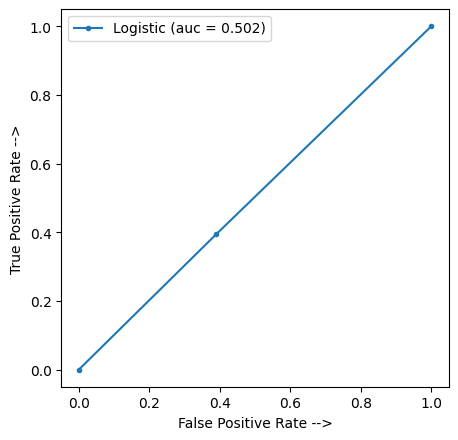

In [26]:
#ROC CURVE:
from sklearn.metrics import roc_curve, auc

logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_lr)
auc_logistic = auc(logistic_fpr, logistic_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic (auc = %0.3f)' % auc_logistic)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

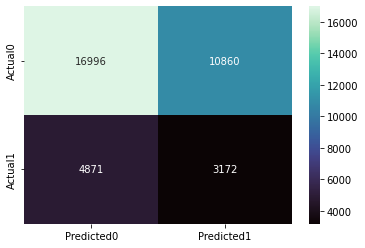

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot(y_true, y_pred):
    labels = unique_labels(y_test)
    column = [f'Predicted{label}' for label in labels]
    indices = [f'Actual{label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns = column, index=indices)
    return sns.heatmap(table, annot = True, fmt = 'd', cmap = 'mako' )

plot(y_test, y_pred_lr)

# **Oversampling**

In [28]:
from imblearn.over_sampling import SMOTE
import numpy as np
#Seeing the value count before oversampling
unique, count = np.unique(y_train, return_counts = True)
y_train_dict_value_count = {k:v for (k,v) in zip(unique, count)}
print("Before oversampling",y_train_dict_value_count)

sm = SMOTE(random_state=12)
x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)

# Seeing the value count after oversampling
unique, count = np.unique(y_train_sm, return_counts = True)
y_train_smote_value_count = {k:v for (k,v) in zip(unique, count)}
print("After oversampling",y_train_smote_value_count)

Before oversampling {0: 194999, 1: 56296}
After oversampling {0: 194999, 1: 194999}


In [29]:
for train_index, test_index in skf.split(x_train_sm, y_train_sm):
    x_train, x_test, y_train, y_test = x_train_sm.iloc[train_index], x_train_sm.iloc[test_index], y_train_sm.iloc[train_index], y_train_sm.iloc[test_index]

In [30]:
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [31]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [32]:


lr = LogisticRegression(class_weight="balanced")
lr.fit(x_train, y_train) #Training the model
y_pred_lr = lr.predict(x_test)
print(y_pred_lr)# printing predictions


#Accuracy Score

from sklearn.metrics import accuracy_score
ovr_lrAccuracy = round(accuracy_score(y_test, y_pred_lr)*100,2)
print("Accuracy of lr after oversampling:",ovr_lrAccuracy)

#F1 Score

from sklearn.metrics import f1_score
ovr_lrF1 = round(f1_score(y_test, y_pred_lr)*100,2)
print("f1_score of lr after oversampling:",ovr_lrF1)

#AUC Score

from sklearn.metrics import roc_auc_score
ovr_lrAuc = round(roc_auc_score (y_test, y_pred_lr)*100,2)
print('AUC Score of lr after oversampling:', ovr_lrAuc)

[0 0 0 ... 0 1 0]
Accuracy of lr after oversampling: 50.26
f1_score of lr after oversampling: 50.36
AUC Score of lr after oversampling: 50.26


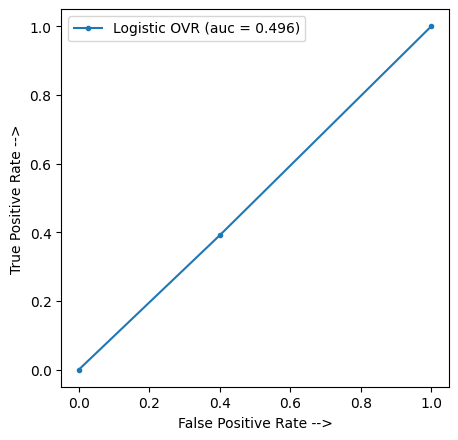

In [ ]:
#ROC CURVE:
from sklearn.metrics import roc_curve, auc, confusion_matrix

logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_lr)
auc_logistic = auc(logistic_fpr, logistic_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic OVR (auc = %0.3f)' % auc_logistic)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()


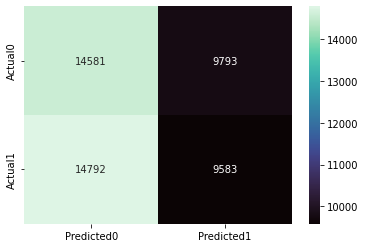

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot(y_true, y_pred):
    labels = unique_labels(y_test)
    column = [f'Predicted{label}' for label in labels]
    indices = [f'Actual{label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns = column, index=indices)
    return sns.heatmap(table, annot = True, fmt = 'd', cmap = 'mako' )

plot(y_test, y_pred_lr)

# Result when we use undersampling on the data

In [ ]:
x=mBusData[['FC1_Read_Input_Register','FC2_Read_Discrete_Value','FC3_Read_Holding_Register','FC4_Read_Coil']]
y=mBusData['label' ]

In [ ]:
for train_index, test_index in skf.split(x,y):
    x_train, x_test, y_train, y_test = x.iloc[train_index], x.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from collections import Counter

#Seeing the value count before oversampling
print("Before undersampling", Counter(y_train))

rus = RandomUnderSampler(random_state=12)
x_undsampled, y_undsampled = rus.fit_resample(x_train, y_train)

# Seeing the value count after oversampling
print("After undersampling",Counter(y_undsampled))

In [ ]:
# --------------------------Logistic Reg -----------------------------------

for train_index, test_index in skf.split(x_undsampled, y_undsampled):
    x_train, x_test, y_train, y_test = x_undsampled.iloc[train_index], x_undsampled.iloc[test_index], y_undsampled.iloc[train_index], y_undsampled.iloc[test_index]

lr = LogisticRegression(class_weight="balanced")
lr.fit(x_train, y_train) #Training the model
y_pred_lr = lr.predict(x_test)
print(y_pred_lr)# printing predictions


#Accuracy Score

from sklearn.metrics import accuracy_score
und_lrAccuracy = round(accuracy_score(y_test, y_pred_lr)*100,2)
print("Accuracy of lr undersampled : ",und_lrAccuracy)

#F1 Score

from sklearn.metrics import f1_score
und_lrF1 = round(f1_score(y_test, y_pred_lr)*100,2)
print("f1_score of lr undersampled: ",und_lrF1)

#AUC Score

from sklearn.metrics import roc_auc_score
try:
  und_lrAuc = round(roc_auc_score (y_test, y_pred_lr)*100,2)
  print('AUC Score of lr undersampled:', und_lrAuc)
except ValueError:
    pass

[0 0 0 ... 0 1 0]
Accuracy of lr undersampled :  50.44
f1_score of lr undersampled:  38.32
AUC Score of lr undersampled: 50.44


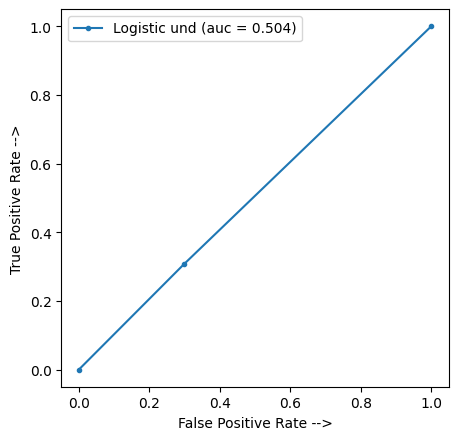

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_lr)
auc_logistic = auc(logistic_fpr, logistic_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic und (auc = %0.3f)' % auc_logistic)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

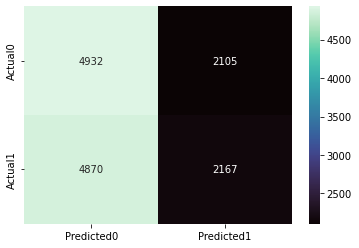

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot(y_true, y_pred):
    labels = unique_labels(y_test)
    column = [f'Predicted{label}' for label in labels]
    indices = [f'Actual{label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns = column, index=indices)
    return sns.heatmap(table, annot = True, fmt = 'd', cmap = 'mako' )

plot(y_test, y_pred_lr)

In [ ]:
# from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# confusion_matrix(y_test,y_pred_logistic)

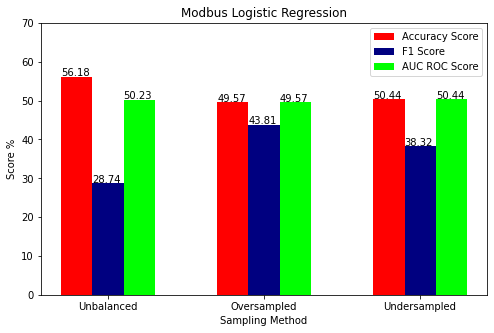

In [ ]:
#Plotting a bar graph to compare the accuracy scores of the different scoring metrics
all_accuracy_scores = [lrAccuracy, ovr_lrAccuracy, und_lrAccuracy]
all_f1_scores = [lrF1, ovr_lrF1, und_lrF1]
all_auc_roc_scores = [lrAuc, ovr_lrAuc, und_lrAuc]

x_labels = ['Unbalanced', 'Oversampled', 'Undersampled']

def autolabel(rectangle_group):
    for rect in rectangle_group:
        height = rect.get_height()

        ax.annotate(str(height), xy = (rect.get_x(), height+.15))

width = 0.2

x_all_accuracy_score = [x-width for x in range (len(all_accuracy_scores))]
x_all_f1_score = [x for x in range (len(all_f1_scores))]
x_all_auc_roc_score = [x+width for x in range (len(all_auc_roc_scores))]

fig,ax = plt.subplots(figsize = (8, 5))
rect1 = ax.bar(x_all_accuracy_score ,all_accuracy_scores, width, label='Accuracy Score', color = 'red')
rect2 = ax.bar(x_all_f1_score, all_f1_scores, width, label='F1 Score', color='navy')
rect3 = ax.bar(x_all_auc_roc_score, all_auc_roc_scores, width, label='AUC ROC Score', color='lime')
plt.xticks([x for x in range(len(x_labels))], x_labels)
ax.set_title('Modbus Logistic Regression')
ax.set_xlabel('Sampling Method')
ax.set_ylabel('Score %')
plt.ylim([0, 70])
ax.legend()

autolabel(rect1)
autolabel(rect2)
autolabel(rect3)
plt.show()